# Notebook for exercise 1 


1. So at first i will try to build models that have fully connected layers. These models are described as Multi-Layer Perceptrons (MLPs). An MLP is a type of feedforward neural network consisting of input, hidden and output layers. I know though that MLPs are less effective for image classification problems. So let's see how well the following models perform.

## 0. Get data ready

### 0.1 Create train and test sets

In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting
import numpy as np

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)

file_names.append("test_batch")

for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



### 0.2 Preprocessing the data
From task 0 i am going to use:
* StandardScaler
* PCA

I have seen from the previous exercise that these two, improve my accuracy

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch

#Feature scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#PCA
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Turn data into tensors
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)






In [3]:
X_train.shape, X_test.shape

(torch.Size([50000, 100]), torch.Size([10000, 100]))

### 0.3 Device agnostic code

In [4]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Build a linear model

I know that the problem of the classification of the CIFAR-10 dataset is non linear, but i want to see how well a linear model performs. 

### 1.1 Build a linear model



In [11]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use only linear layers (No ReLU)
class linear_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model1_linear = linear_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model1_linear

linear_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 1.2 Create Loss function and Optimizer

* I am wokring on a multiclass classification problem, so i will use the `nn.CrossEntropyLoss()` method as my loss function.
* For the optimizer i will use the Stochastic Gradient Descent (`SGD`)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model1_linear.parameters(),
                            lr=0.01)


### 1.3 Create train and test loop function

In [13]:
#put the data to target device (in my case the gpu)
#this will make my code run faster

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    def reset(self):
        self.train_loss_values[:] = np.nan
        self.test_loss_values[:] = np.nan
        self.train_acc_values[:] = np.nan
        self.test_acc_values[:] = np.nan
    
    

In [14]:
from sklearn.metrics import accuracy_score 
import time

def train_test_fn(model,epochs,X_train,X_test,y_train,y_test,metrics):
    metrics.reset() # Reset metrics before each call
    start_time = time.time()  # Start the timer
    
    for epoch in range(epochs):
        ### Training
        model.train()
        #1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1) # logits -> pred probabilities -> pred labels
        #2. Calculate loss and accuracy
        loss = loss_fn(y_logits,y_train)
        metrics.train_loss_values[epoch] = loss
        # train_loss_values[epoch] = loss
        acc = accuracy_score(y_train.cpu(),y_pred.cpu())
        metrics.train_acc_values[epoch] = acc
        # train_acc_values[epoch] = acc
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backwards
        loss.backward()
        #5.Optimizer step
        optimizer.step()
    
        ###Testing
        model.eval()
        with torch.inference_mode():
            #1. Forward pass
            test_logits = model(X_test)
            test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            #2. Calculate the test loss and accuracy
            test_loss = loss_fn(test_logits,y_test)
            metrics.test_loss_values[epoch] = test_loss
            # test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu(),test_pred.cpu())
            metrics.test_acc_values[epoch] = test_acc
            # test_acc_values[epoch] = test_acc

        #Print the results
        if epoch % (epochs//10) == 0 or epoch == epochs-1:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

    end_time = time.time()  # End the timer
    total_time = end_time - start_time  # Calculate total time
    print(f"Training completed in: {total_time:.2f} seconds")





In [15]:
epochs =200

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model1_linear,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics)

Epoch: 0 | Loss: 2.75669, Acc: 0.09% | Test Loss: 2.37612, Test Acc: 0.16%
Epoch: 20 | Loss: 1.92728, Acc: 0.32% | Test Loss: 1.91889, Test Acc: 0.33%
Epoch: 40 | Loss: 1.86006, Acc: 0.36% | Test Loss: 1.85598, Test Acc: 0.36%
Epoch: 60 | Loss: 1.82849, Acc: 0.37% | Test Loss: 1.82577, Test Acc: 0.37%
Epoch: 80 | Loss: 1.80907, Acc: 0.38% | Test Loss: 1.80722, Test Acc: 0.38%
Epoch: 100 | Loss: 1.79564, Acc: 0.38% | Test Loss: 1.79449, Test Acc: 0.39%
Epoch: 120 | Loss: 1.78568, Acc: 0.39% | Test Loss: 1.78514, Test Acc: 0.39%
Epoch: 140 | Loss: 1.77794, Acc: 0.39% | Test Loss: 1.77794, Test Acc: 0.39%
Epoch: 160 | Loss: 1.77174, Acc: 0.39% | Test Loss: 1.77221, Test Acc: 0.39%
Epoch: 180 | Loss: 1.76665, Acc: 0.39% | Test Loss: 1.76753, Test Acc: 0.39%
Epoch: 199 | Loss: 1.76260, Acc: 0.40% | Test Loss: 1.76381, Test Acc: 0.40%
Training completed in: 8.48 seconds


### 1.4 Save the `model1_linear` in `Ex1_Models` folder

In [16]:
from pathlib import Path

def save_model(model,model_name):
    #1. Create models directory
    MODEL_PATH = Path("Ex1_Models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    #2. Create model save path
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    
    #3. save the model state dict
    print(f"Saving model to:{MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),f=MODEL_SAVE_PATH)


In [17]:
save_model(model=model1_linear,
           model_name="model1_linear.pth")

Saving model to:Ex1_Models\model1_linear.pth


### 1.5 Plot the `model1_liner`

In [26]:
import matplotlib.pyplot as plt

def plot_loss_acc_fn(metrics,model_name):
    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss (" + model_name + ")" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.axhline(y=0.4425,color='r',ls='--',label="Best accuracy from Task_0")  #the best accuracy achieved from Task_0 (3NN)
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    
    

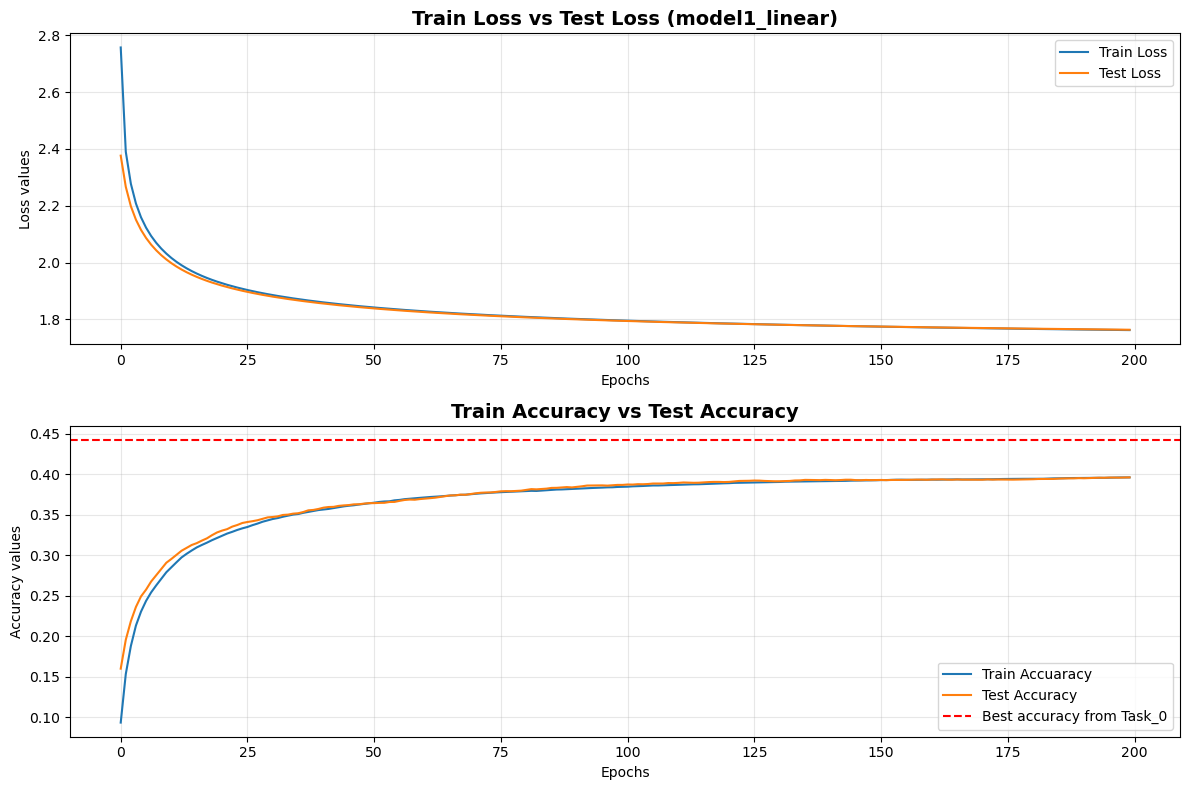

In [27]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model1_linear")

### 1.6. Conclusion

For my first attempt i used a linear model with 2 hidden layers and each hidden layer with 512 hidden units (neurons). Even if a linear model is not suitable for this multiclass classification problem, i notice from the last graph that the accuracy from this not suitable model is close to the best accuracy achieved with 3NN in the previous exercise.

## 2. Build a non linear model

I have a non linear multiclass classification problem , so a will need a non linear model


### 2.1 Create model

Below i have a feedforward neural network with 2 hidden layers and each hidden layer has 512 hidden units. Each hidden layer has a non linear activation function, the `ReLU` , that helps the model capture complex patterns. 

In [29]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class relu_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(  #nn.Sequential -> straightforward feedforward models
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model2_relu = relu_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=512).to(device)

model2_relu

relu_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

### 2.2 Loss function and optimizer

- Loss function: `nn.CrossEntropyLoss()` suitable for multiclass classification tasks
- Optimizer: `torch.optim.SGD`, updates model parameters to minimimze the loss using Stochastic Gradient Descent

In [30]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model2_relu.parameters(),
                            lr=0.01)

### 2.3 Train and test loop

In [31]:
# call train_test_fn to train and test my model
epochs = 500

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model2_relu,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics = metrics)

Epoch: 0 | Loss: 2.40964, Acc: 0.11% | Test Loss: 2.34103, Test Acc: 0.12%
Epoch: 50 | Loss: 1.96645, Acc: 0.31% | Test Loss: 1.96073, Test Acc: 0.32%
Epoch: 100 | Loss: 1.86239, Acc: 0.35% | Test Loss: 1.86171, Test Acc: 0.35%
Epoch: 150 | Loss: 1.80087, Acc: 0.37% | Test Loss: 1.80333, Test Acc: 0.37%
Epoch: 200 | Loss: 1.75825, Acc: 0.39% | Test Loss: 1.76285, Test Acc: 0.38%
Epoch: 250 | Loss: 1.72563, Acc: 0.40% | Test Loss: 1.73189, Test Acc: 0.39%
Epoch: 300 | Loss: 1.69906, Acc: 0.41% | Test Loss: 1.70684, Test Acc: 0.40%
Epoch: 350 | Loss: 1.67658, Acc: 0.42% | Test Loss: 1.68588, Test Acc: 0.41%
Epoch: 400 | Loss: 1.65711, Acc: 0.42% | Test Loss: 1.66786, Test Acc: 0.42%
Epoch: 450 | Loss: 1.63992, Acc: 0.43% | Test Loss: 1.65212, Test Acc: 0.42%
Epoch: 499 | Loss: 1.62477, Acc: 0.43% | Test Loss: 1.63845, Test Acc: 0.43%
Training completed in: 23.21 seconds


### 2.4 Save the `model2_relu`

In [32]:
save_model(model=model2_relu,
           model_name="model2_relu.pth")

Saving model to:Ex1_Models\model2_relu.pth


### 2.5 PLot the `model2_relu`

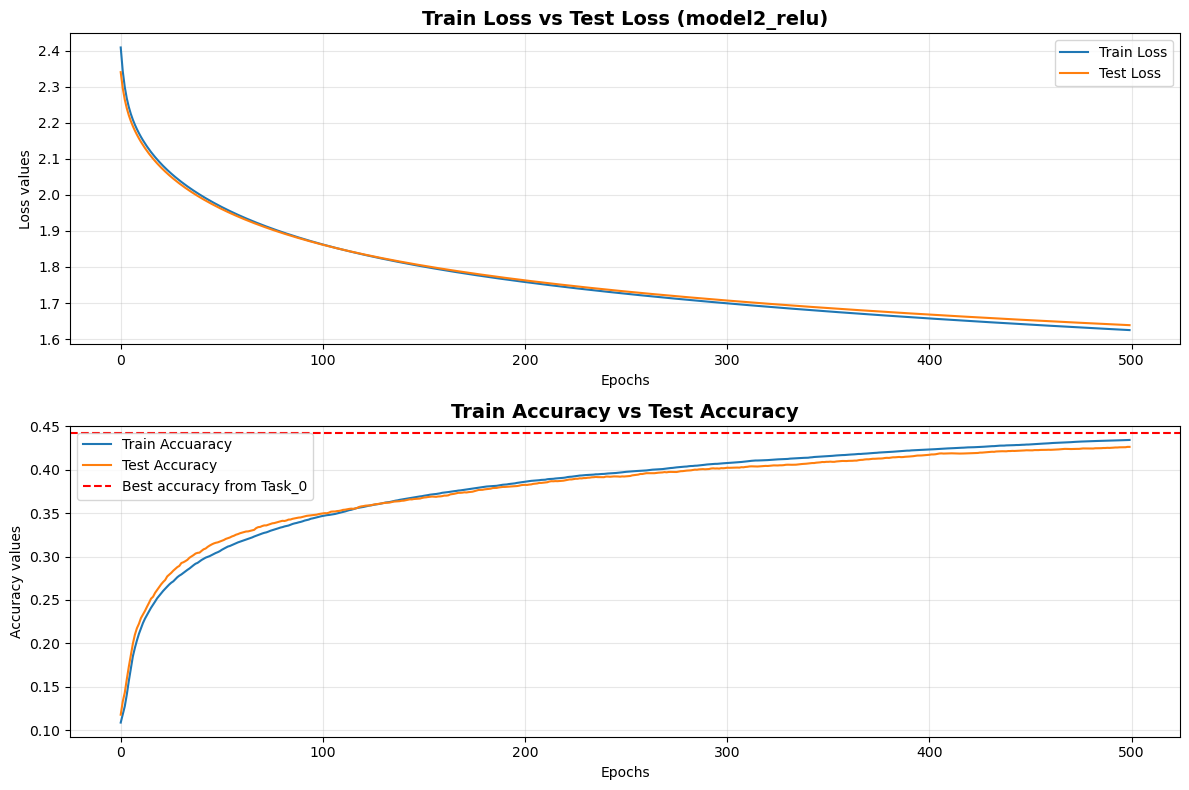

In [33]:
plot_loss_acc_fn(metrics,"model2_relu")

### 2.6 Conclusion for `model2_relu`

As expected the non linear model performs better than the linear one, because we have a non linear problem. From the last graph i can see that the acuuracy of this model is roughly the same as the best accuracy achieved in Task_0.

## 3 Build a non linear model with many hidden units

Now i will try to build a non linear model with 5 hidden layers and 1024 hidden units to see if it performs better. I have a large dataset so, i believe that a deeper model will be more efficient dealing with complex patterns that exist in CIFAR-10 dataset

### 3.1 Create model

In [38]:
from torch import nn
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class deep_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model3_deep = deep_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model3_deep

deep_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)

### 3.2 Loss function and optimizer

In [39]:
#define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model3_deep.parameters(),
                            lr=0.01)

### 3.3 train and test loop

In [40]:
# call train_test_fn to train and test my model
epochs =500

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model3_deep,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.30252, Acc: 0.10% | Test Loss: 2.30223, Test Acc: 0.10%
Epoch: 50 | Loss: 2.28906, Acc: 0.16% | Test Loss: 2.28847, Test Acc: 0.16%
Epoch: 100 | Loss: 2.27221, Acc: 0.19% | Test Loss: 2.27114, Test Acc: 0.19%
Epoch: 150 | Loss: 2.24606, Acc: 0.23% | Test Loss: 2.24418, Test Acc: 0.23%
Epoch: 200 | Loss: 2.20378, Acc: 0.25% | Test Loss: 2.20071, Test Acc: 0.25%
Epoch: 250 | Loss: 2.14390, Acc: 0.26% | Test Loss: 2.13941, Test Acc: 0.26%
Epoch: 300 | Loss: 2.07817, Acc: 0.27% | Test Loss: 2.07256, Test Acc: 0.28%
Epoch: 350 | Loss: 2.02045, Acc: 0.28% | Test Loss: 2.01412, Test Acc: 0.29%
Epoch: 400 | Loss: 1.97331, Acc: 0.30% | Test Loss: 1.96655, Test Acc: 0.30%
Epoch: 450 | Loss: 1.93405, Acc: 0.31% | Test Loss: 1.92717, Test Acc: 0.31%
Epoch: 499 | Loss: 1.90089, Acc: 0.32% | Test Loss: 1.89404, Test Acc: 0.32%
Training completed in: 248.88 seconds


### 3.4 save the `model3_deep`

In [43]:
save_model(model=model3_deep,
           model_name="model3_deep.pth")

Saving model to:Ex1_Models\model3_deep.pth


### 3.5 Plot the `model2_relu_layers`

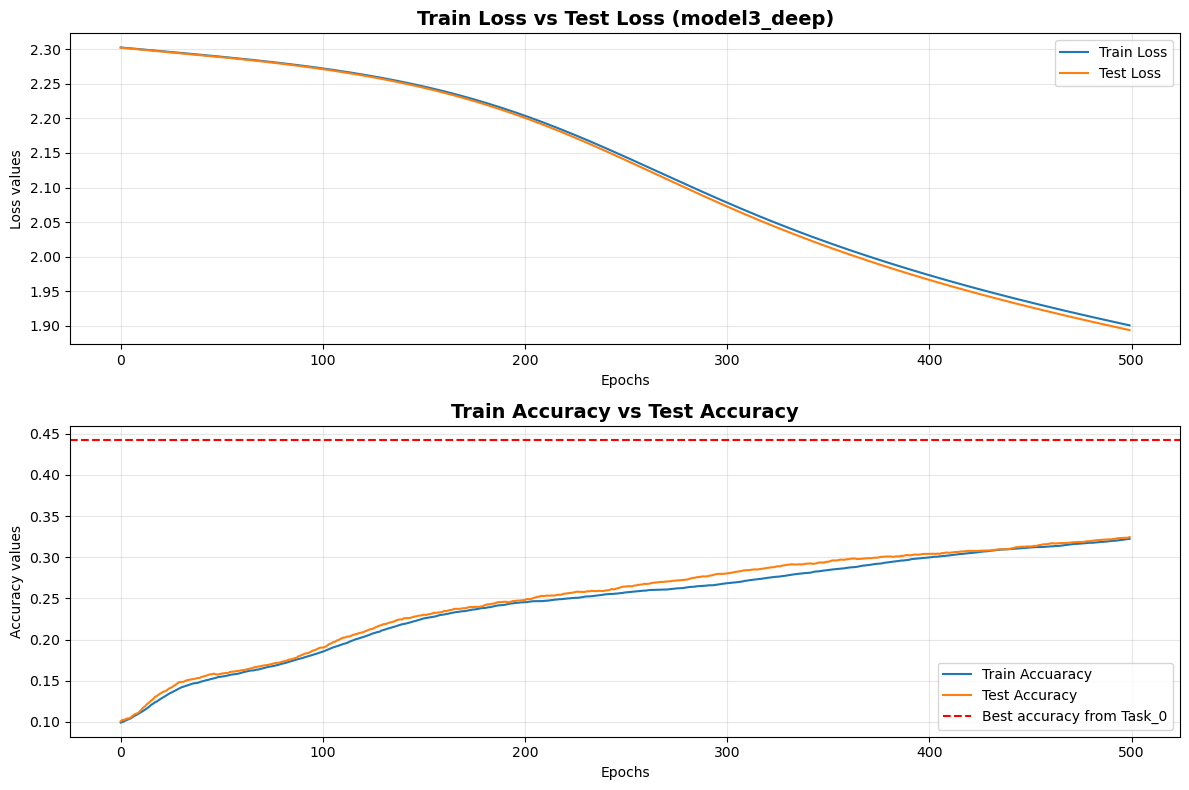

In [44]:
plot_loss_acc_fn(metrics=metrics,
                model_name="model3_deep")

### 3.6 Conclusion for `model3_relu_layers`

I expected better accuracy in 500 epochs, but the convergence was slow and as a result the model didnt have the time it needed to impove its accuracy. I will keep the same  structure (5 hidden layers and 1024 hidden units), but i will also try to make the convergence faster

## 4. Model with Momentum and Batch Normalization

I will keep the same structure as above but since i want to make the convergence faster, i will also implement `Momentum` in my optimizer and i will add `Batch Normalization` to normalize the inputs of each layer during training in order to have mean of 0 and a variance of 1.

* Momentum prevents the model from getting stuck in unhelpfull updates by maintaining the direction of the previous steps.
* Normalizing the input of each layer, reduces the risk of exploding or vanishing gradients and prevents the model from getting stuck in a local minima
  
Let's see if the above make the convergence faster and as a result improve the accuracy

### 4.1 Create a model

In [45]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class norma_mom_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model4_norma_mom = norma_mom_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model4_norma_mom

norma_mom_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=1024, bias=True)
    (16): BatchNorm1d(1

### 4.2 Loss function and optimizer 



In [47]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model4_norma_mom.parameters(),lr=0.01,momentum=0.9)

### 4.3 Train and test loop

In [48]:
# call train_test_fn to train and test my model
epochs =500

# Create a metrics object
metrics = my_Metrics(epochs=epochs)

train_test_fn(model=model4_norma_mom,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.34975, Acc: 0.11% | Test Loss: 2.30219, Test Acc: 0.10%
Epoch: 50 | Loss: 1.22662, Acc: 0.58% | Test Loss: 1.45829, Test Acc: 0.49%
Epoch: 100 | Loss: 0.70656, Acc: 0.80% | Test Loss: 1.39210, Test Acc: 0.51%
Epoch: 150 | Loss: 0.25461, Acc: 0.97% | Test Loss: 1.53377, Test Acc: 0.51%
Epoch: 200 | Loss: 0.06818, Acc: 1.00% | Test Loss: 1.77807, Test Acc: 0.50%
Epoch: 250 | Loss: 0.02736, Acc: 1.00% | Test Loss: 1.96331, Test Acc: 0.50%
Epoch: 300 | Loss: 0.01563, Acc: 1.00% | Test Loss: 2.08123, Test Acc: 0.50%
Epoch: 350 | Loss: 0.01056, Acc: 1.00% | Test Loss: 2.16479, Test Acc: 0.50%
Epoch: 400 | Loss: 0.00781, Acc: 1.00% | Test Loss: 2.22955, Test Acc: 0.50%
Epoch: 450 | Loss: 0.00612, Acc: 1.00% | Test Loss: 2.28231, Test Acc: 0.50%
Epoch: 499 | Loss: 0.00501, Acc: 1.00% | Test Loss: 2.32587, Test Acc: 0.50%
Training completed in: 408.19 seconds


### 4.4 Save the `model4_relu_layers`

In [52]:
save_model(model=model4_norma_mom,
           model_name="model4_norma_mom.pth")

Saving model to:Ex1_Models\model4_norma_mom.pth


### 4.5 Plot the `model4_relu_layers`

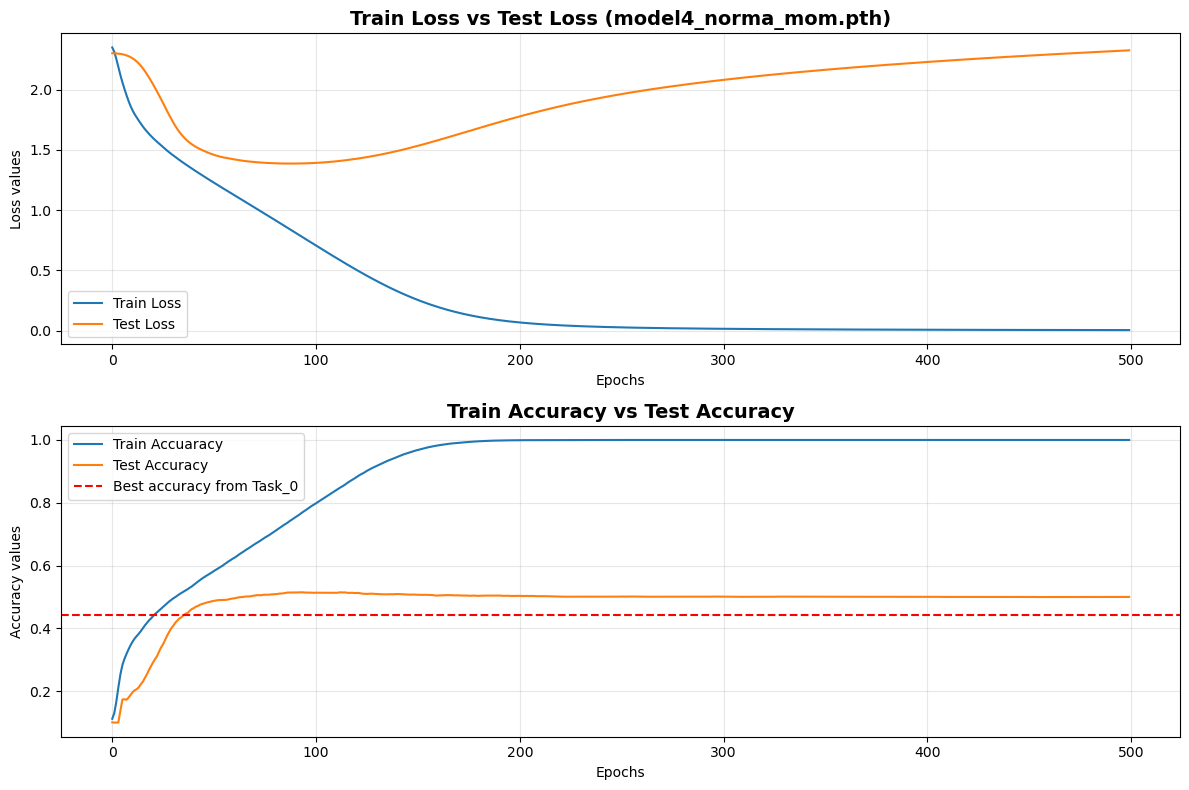

In [53]:
plot_loss_acc_fn(metrics=metrics,
                 model_name="model4_norma_mom.pth")

### 4.6 Conclusion for `model4_norma_mom`

I notice that the convergence of this model is faster than the previous model (`mode3_deep`), but i have overfitting. To prevent this in my next model i will also use dropout.

## 5. Build model 

In this model i will use:
- Momentum
- Batch Normalization

and to prevent overfitting i will also use
- Dropout

Dropout randomly sets to 0 a fractiion of the neurons in the network. This prevents the model from relying too much on a neuron, making it learn more robust features

### 5.1 Create a model

In [60]:
NUM_FEATURES = X_train.shape[1]  # NUM_FEATURES = columns
NUM_CLASSES = 10

#Below i will use non linear layers (ReLU)
class dropout_model(nn.Module):
    def __init__(self,input_features,output_features,hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)            
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of model_1 and send it to the target device
model5_dropout = dropout_model(input_features=NUM_FEATURES,
                  output_features=NUM_CLASSES,
                  hidden_units=1024).to(device)

model5_dropout

dropout_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=1024, out_features=1024, bias=True)
    (17): BatchNorm1d(1024, eps=1e-05, 

### 5.2 Loss Function and optimizer

In [61]:
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#define the optimizer WITH MOMENTUM
optimizer = torch.optim.SGD(params=model5_dropout.parameters(),lr=0.01,momentum=0.95)

### 5.3 Train and test loop

In [62]:
epochs=500
# Create a metrics object
metrics = my_Metrics(epochs)

train_test_fn(model=model5_dropout,
              epochs=epochs,
              X_train=X_train,
              X_test=X_test,
              y_train=y_train,
              y_test=y_test,
              metrics=metrics
)

Epoch: 0 | Loss: 2.39382, Acc: 0.10% | Test Loss: 2.30292, Test Acc: 0.10%
Epoch: 50 | Loss: 1.95084, Acc: 0.28% | Test Loss: 2.24781, Test Acc: 0.22%
Epoch: 100 | Loss: 1.78096, Acc: 0.35% | Test Loss: 2.08565, Test Acc: 0.32%
Epoch: 150 | Loss: 1.68749, Acc: 0.39% | Test Loss: 1.90745, Test Acc: 0.37%
Epoch: 200 | Loss: 1.63107, Acc: 0.41% | Test Loss: 1.81024, Test Acc: 0.40%
Epoch: 250 | Loss: 1.58539, Acc: 0.43% | Test Loss: 1.73777, Test Acc: 0.42%
Epoch: 300 | Loss: 1.55371, Acc: 0.44% | Test Loss: 1.68379, Test Acc: 0.43%
Epoch: 350 | Loss: 1.52101, Acc: 0.45% | Test Loss: 1.63593, Test Acc: 0.45%
Epoch: 400 | Loss: 1.49126, Acc: 0.47% | Test Loss: 1.59625, Test Acc: 0.46%
Epoch: 450 | Loss: 1.46990, Acc: 0.47% | Test Loss: 1.56214, Test Acc: 0.47%
Epoch: 499 | Loss: 1.44669, Acc: 0.48% | Test Loss: 1.53522, Test Acc: 0.48%
Training completed in: 1272.36 seconds


### 5.4 Save the `model5_dropout`

In [63]:
save_model(model=model5_dropout,model_name="model5_dropout.pth")

Saving model to:Ex1_Models\model5_dropout.pth


### 5.5 Plot `model5_dropout`

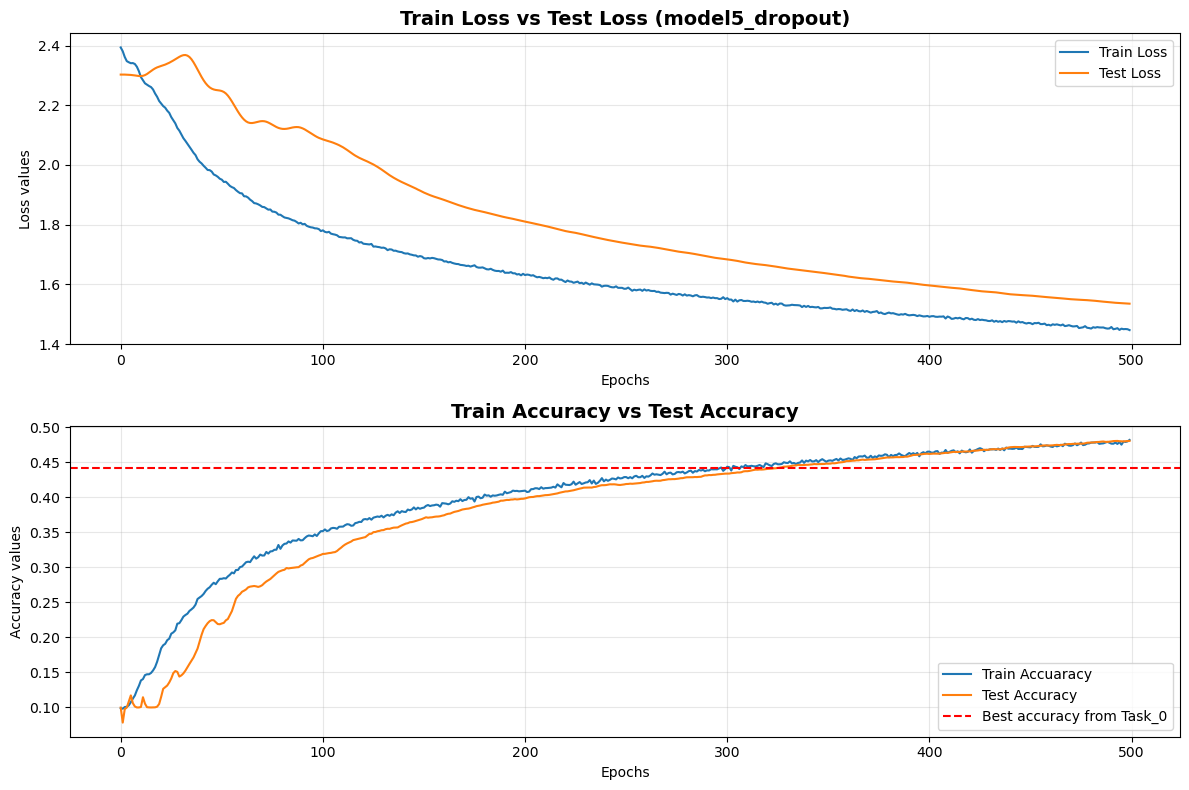

In [64]:
plot_loss_acc_fn(metrics=metrics,model_name="model5_dropout")

### 5.6 Conclusion for `model5_dropout`

Adding the dropout at each hidden layer of the same model that i had before (`model4_norma_mom`), prevented the overfitting. So looking at the two plots, i can say that this is the best MLP model that i have, but i can also say that the performance of this model isn't good enough for our classification problem. This was expected as i knew that MLPs are less effective for these kinds of problems. On the other hand Convolutional Neural Networks perform better. Next up let's see how CNNs perform for the same problem